In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [17]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)

Dropped 24 columns


c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def optimize_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1.0, 'sqrt', 'log2']
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_family_models(df):
    optimized_models = {}
    families = list(df['steel_family'].unique())
    for family in tqdm(families, desc="Optimizing Models", unit="family"):
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        optimization_results = optimize_hyperparameters(X_train, y_train)
        best_model = optimization_results['best_estimator']
        best_model.fit(X_train, y_train)
        
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        optimized_models[family] = {
            'model': best_model,
            'best_params': optimization_results['best_params'],
            'best_score': optimization_results['best_score'],
            'train_mse': mean_squared_error(y_train, y_pred_train),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test)
        }
    return optimized_models

In [28]:
# # Run optimization
# optimized_family_models = train_optimized_family_models(train_scaled_df)

# for family, model_info in optimized_family_models.items():
#     print(f"Family: {family}")
#     print(f"Best Parameters: {model_info['best_params']}")
#     print(f"Best CV Score (MSE): {model_info['best_score']}")
#     print(f"Test MSE: {model_info['test_mse']}")
#     print(f"Test R2: {model_info['test_r2']}")

# Family: CMn
# Best Parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
# Best CV Score (MSE): 0.03911500158250465
# Test MSE: 0.039220056517814274
# Test R2: 0.6972855582368966
# Family: IF
# Best Parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
# Best CV Score (MSE): 0.07053096351833663
# Test MSE: 0.07078659003356745
# Test R2: 0.6518490759619813
# Family: HSLA
# Best Parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Best CV Score (MSE): 0.020651079427269632
# Test MSE: 0.020220584773076537
# Test R2: 0.7733940539686319

In [29]:
optimized_family_models_dict = {'CMn': {'model': RandomForestRegressor(max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 300}
   },
 'IF': {'model': RandomForestRegressor(max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 300}
   },
 'HSLA': {'model': RandomForestRegressor(max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100}
   }
}

In [31]:
def train_optimized_models(df, optimized_models_dict):
    trained_models = {}
    for family, model_config in optimized_models_dict.items():
        # Filter data for the specific steel family
        family_data = df[df['steel_family'] == family]
        
        # Separate features and target
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Create the model using the best estimator from grid search
        model = model_config['model']
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred_test = model.predict(X_test)
        
        # Store the model with performance metrics
        trained_models[family] = {
            'model': model,
            'test_r2': r2_score(y_test, y_pred_test),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'test_mae': mean_absolute_error(y_test, y_pred_test)
        }
    
    return trained_models

In [ ]:
tmp1 = train_optimized_models(train_scaled_df, optimized_family_models_dict)

In [40]:
optimized_family_models

{'CMn': {'model': RandomForestRegressor(n_estimators=300, random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 300},
  'best_score': 0.03911500158250465,
  'train_mse': 0.005098760109428909,
  'test_mse': 0.039220056517814274,
  'train_r2': 0.9614892646907356,
  'test_r2': 0.6972855582368966},
 'IF': {'model': RandomForestRegressor(min_samples_leaf=2, n_estimators=300, random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 300},
  'best_score': 0.07053096351833663,
  'train_mse': 0.012290691587332411,
  'test_mse': 0.07078659003356745,
  'train_r2': 0.9360065226112136,
  'test_r2': 0.6518490759619813},
 'HSLA': {'model': RandomForestRegressor(random_state=42),
  'best_params': {'max_depth': None,
   'max_features': 1.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100}

In [35]:
tmp1

{'CMn': {'model': RandomForestRegressor(n_estimators=300, random_state=42),
  'test_r2': 0.6972855582368966,
  'test_mse': 0.039220056517814274,
  'test_mae': 0.13719910991353376},
 'IF': {'model': RandomForestRegressor(min_samples_leaf=2, n_estimators=300, random_state=42),
  'test_r2': 0.6518490759619813,
  'test_mse': 0.07078659003356745,
  'test_mae': 0.2057577014596681},
 'HSLA': {'model': RandomForestRegressor(random_state=42),
  'test_r2': 0.7733940539686319,
  'test_mse': 0.020220584773076537,
  'test_mae': 0.09750937327044966}}

In [37]:
def plot_predicted_vs_actual(optimized_models, df):
    plt.figure(figsize=(15, 5 * len(optimized_models)))
    
    for i, (family, model_info) in enumerate(optimized_models.items(), 1):
        plt.subplot(len(optimized_models), 1, i)
        
        # Recreate train/test split
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Predict
        y_pred_test = model_info['model'].predict(X_test)
        
        # Plot
        plt.scatter(y_test, y_pred_test, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{family} - Predicted vs Actual R-Value')
        plt.xlabel('Actual R-Value')
        plt.ylabel('Predicted R-Value')
        
        # Annotate with R² and MSE
        plt.text(0.05, 0.95, 
                 f"Test R²: {model_info['test_r2']:.4f}\n" +
                 f"Test MSE: {model_info['test_mse']:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

KeyError: 'test_r2'

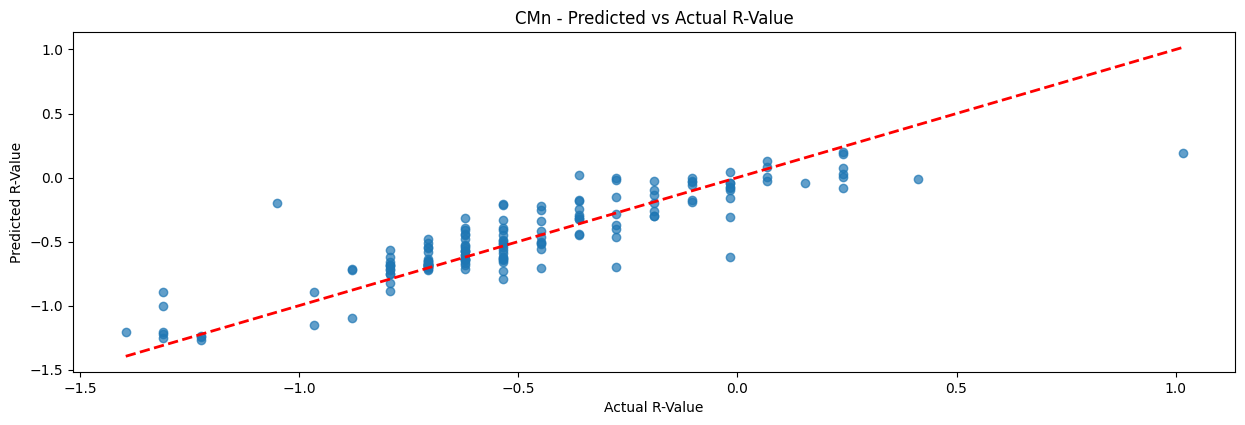

In [ ]:
plot_predicted_vs_actual(optimized_family_models, test_scaled_df)